In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Task for 1D

Make an amplifier for the gaussian, that amplifies the gaussian input by a factor of 2, while maintaining the `PDF = 1`. Dataset is generated using the following.

$$
\phi_{\mu,\sigma^2}(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\left(\frac{x-\mu}{2\sigma}\right)^2}
$$

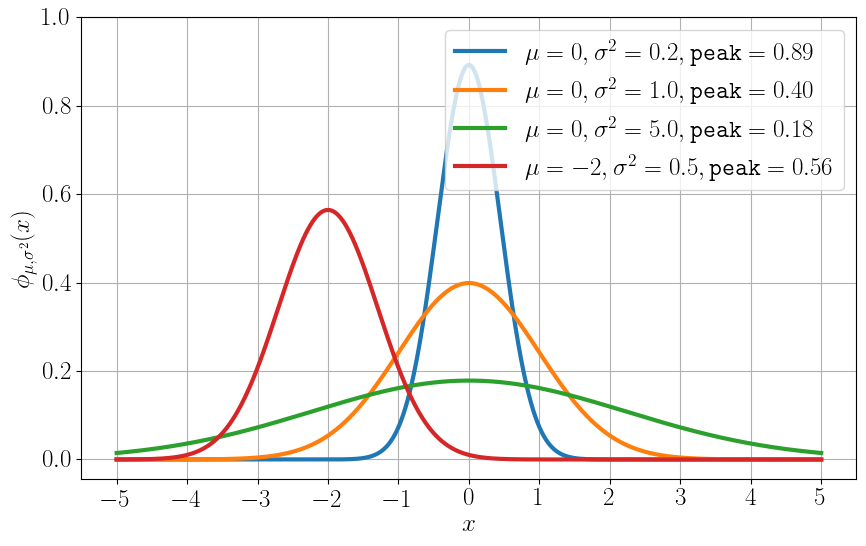

In [2]:
import numpy as np
import torch

class Gauss:
    _sqrt_two_pi = 1.0 / np.sqrt(2 * np.pi)
    def __init__(self, *, mu, sigma=None, var=None):
        if not ((sigma is None) ^ (var is None)):
            raise ValueError("Either sigma or var must be set!")
        self.mu = mu
        if sigma is None:
            self.variance = var
        else:
            self.sigma = sigma
        
    def __call__(self, x, *, mu=None, var=None):
        if mu is not None:
            self.mu = mu
        if var is not None:
            self.variance = var
        centered_x_2 = (x - self.mu)**2
        return self._normalization * torch.exp(-self._power * centered_x_2)
    
    @property
    def mu(self):
        return self._mu
    @mu.setter
    def mu(self, mu):
        self._mu = mu
    
    @property
    def sigma(self):
        return self._sigma
    @sigma.setter
    def sigma(self, sigma):
        self.set_sigma_variance(sigma=sigma)
        
    @property
    def variance(self):
        return self._variance
    @variance.setter
    def variance(self, v):
        if v < 0:
            raise ValueError("Variance must be positive!")
        self.set_sigma_variance(variance=v)

    def set_sigma_variance(self, *, sigma=None, variance=None):
        if sigma is not None:
            self._sigma = sigma
            self._variance = self._sigma**2
        elif variance is not None:
            self._sigma = np.sqrt(variance)
            self._variance = variance

        if self._variance == 0:
            self._variance = 1e-9
        self._power = 1.0 / (2 * self._variance)
        self._normalization = np.sqrt(self._power / np.pi)
        
mus = [0, 0, 0, -2]
vs = [0.2, 1.0, 5.0, 0.5]
step_size = 0.01
x = torch.arange(-5, 5.01, step_size)

gauss = Gauss(mu=0.0, var=0.0)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for idx in range(len(mus)):
    y = gauss(x, mu=mus[idx], var=vs[idx])
    ax.plot(x, y, label=f'$\mu={mus[idx]}, \sigma^2={vs[idx]}, \mbox{{peak}}={y.max():.2f}$')
ax.grid('both')
ax.set_ylabel('$\phi_{\mu,\sigma^2}(x)$')
ax.set_xlabel('$x$')
ax.set_xticks(np.arange(-5, 5.01, 1))
ax.set_yticks(np.arange(0, 1.01, 0.2))
ax.legend()

tensor(1.)
tensor(1.)
tensor(1.0000)
tensor(1.)


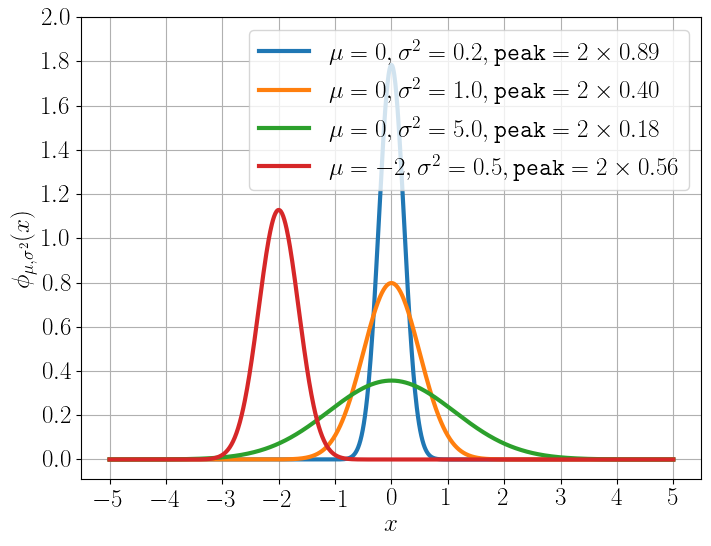

In [3]:
import copy
def amplify_gauss(gauss_object, amplification):
    new_gauss = copy.deepcopy(gauss_object)
    new_gauss.sigma = new_gauss.sigma / amplification
    return new_gauss

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for idx in range(len(mus)):
    gauss = amplify_gauss(Gauss(mu=mus[idx], var=vs[idx]), 2)
    y = gauss(x)    
    ax.plot(x, y, label=f'$\mu={mus[idx]}, \sigma^2={vs[idx]}, \mbox{{peak}}=2 \\times{y.max()/2:.2f}$')
    print(y.sum() * step_size)
ax.grid('both')
ax.set_ylabel('$\phi_{\mu,\sigma^2}(x)$')
ax.set_xlabel('$x$')
ax.set_xticks(np.arange(-5, 5.01, 1))
ax.set_yticks(np.arange(0, 2.01, 0.2))
ax.legend()

In [4]:
def generate_data(x, *, batch_size, mu_minmax, var_minmax):
    shared_x = x
    mu_min = mu_minmax[0]
    mu_range = mu_minmax[1] - mu_minmax[0]
    var_min = var_minmax[0]
    var_range = var_minmax[1] - var_minmax[0]
    
    mu_variance = torch.rand(batch_size, 2)
    mu_variance[:, 0] = mu_variance[:, 0] * mu_range + mu_min
    mu_variance[:, 1] = mu_variance[:, 1] * var_range + var_min
    
    y_data = mu_variance.to(torch.float32)
    x_data = []
    for mv in y_data:
        x_gen = Gauss(mu=mv[0], var=mv[1])(x)
        x_data.append(x_gen)
    x_data = torch.stack(x_data)
    x_data.unsqueeze_(1)
    x_data.requires_grad = False
    y_data.requires_grad = False
#     print('X data:', x_data)
#     print('Y data:', y_data)
    return x_data, y_data

x_data = torch.arange(-5, 5.01, 0.5)
generate_data(x,
              batch_size=4,
              mu_minmax=[-3, 3],
              var_minmax=[0, 3])[1]

tensor([[1.7342, 0.6335],
        [2.2374, 0.7528],
        [0.4320, 1.9318],
        [0.2745, 0.6289]])

### Convolution

In [5]:
import torch
from torch import nn
from torchsummary import summary

class Mean(nn.Module):
    def forward(self, x):
        return torch.mean(x, dim=-1)

class EncoderModel(nn.Module):
    def __init__(self):
        super(EncoderModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 3, 7, stride=3)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(3, 5, 5, stride=3)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(5, 7, 3, stride=3)
        self.relu3 = nn.ReLU()
        
        self.conv_squeeze = nn.Conv1d(7, 1, 1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(36, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv_squeeze(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

encoder_model = EncoderModel()
summary(encoder_model, (1, 1001), device='cpu')

--------------------------------------------------------------
        Layer (type)              Output Shape         Param #
            Conv1d-1              [-1, 3, 332]              24
              ReLU-2              [-1, 3, 332]               0
            Conv1d-3              [-1, 5, 110]              80
              ReLU-4              [-1, 5, 110]               0
            Conv1d-5               [-1, 7, 36]             112
              ReLU-6               [-1, 7, 36]               0
            Conv1d-7               [-1, 1, 36]               8
           Flatten-8                  [-1, 36]               0
            Linear-9                   [-1, 2]              74
     EncoderModel-10                   [-1, 2]             298
Total params: 596
Trainable params: 596
Non-trainable params: 0
--------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.03
--

(tensor(596), tensor(596))

In [6]:
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available else 'cpu'

class CustomLoss:
    def __init__(self, a, b):
        self.a = a
        self.b = b
        self.var = nn.SmoothL1Loss()
        self.mean = nn.SmoothL1Loss()
    def __call__(self, output, target):
        mean_loss = self.a * self.mean(output[:, 0], target[:, 0])
        var_loss = self.b * self.var(output[:, 1], target[:, 1])
#         if (output[:, 1] < 0).any():
#             var_loss += 10
        return mean_loss + var_loss

encode_model = EncoderModel()
encode_model = encode_model.to(device)

In [7]:
# criterion = nn.MSELoss()
# criterion = nn.KLDivLoss()
# criterion = nn.SmoothL1Loss()
criterion = CustomLoss(1.0, 2.0)
optimizer = optim.Adadelta(encode_model.parameters(), lr=0.125)

EPOCHS = 31
batch_size = 2048
x_axis = torch.arange(-5.0, 5.0+step_size, step_size).to(device)
mu_minmax = [-2.5, 2.5]
var_minmax = [0.0, 5.0]

x_data, y_data = generate_data(x_axis,
                               batch_size=batch_size,
                               mu_minmax=mu_minmax,
                               var_minmax=var_minmax)
x_data = x_data.to(device)
y_data = y_data.to(device)
encode_model = encode_model.to(device)

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    
    y_hat = encode_model(x_data)
    loss = criterion(y_hat, y_data)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0 or epoch + 1 == EPOCHS:
        print(f'Epoch: {epoch+1}/{EPOCHS}\tLoss: {loss.item()}')

Epoch: 10/31	Loss: 4.632556438446045
Epoch: 20/31	Loss: 4.589905738830566
Epoch: 30/31	Loss: 4.522008895874023
Epoch: 31/31	Loss: 4.513123035430908


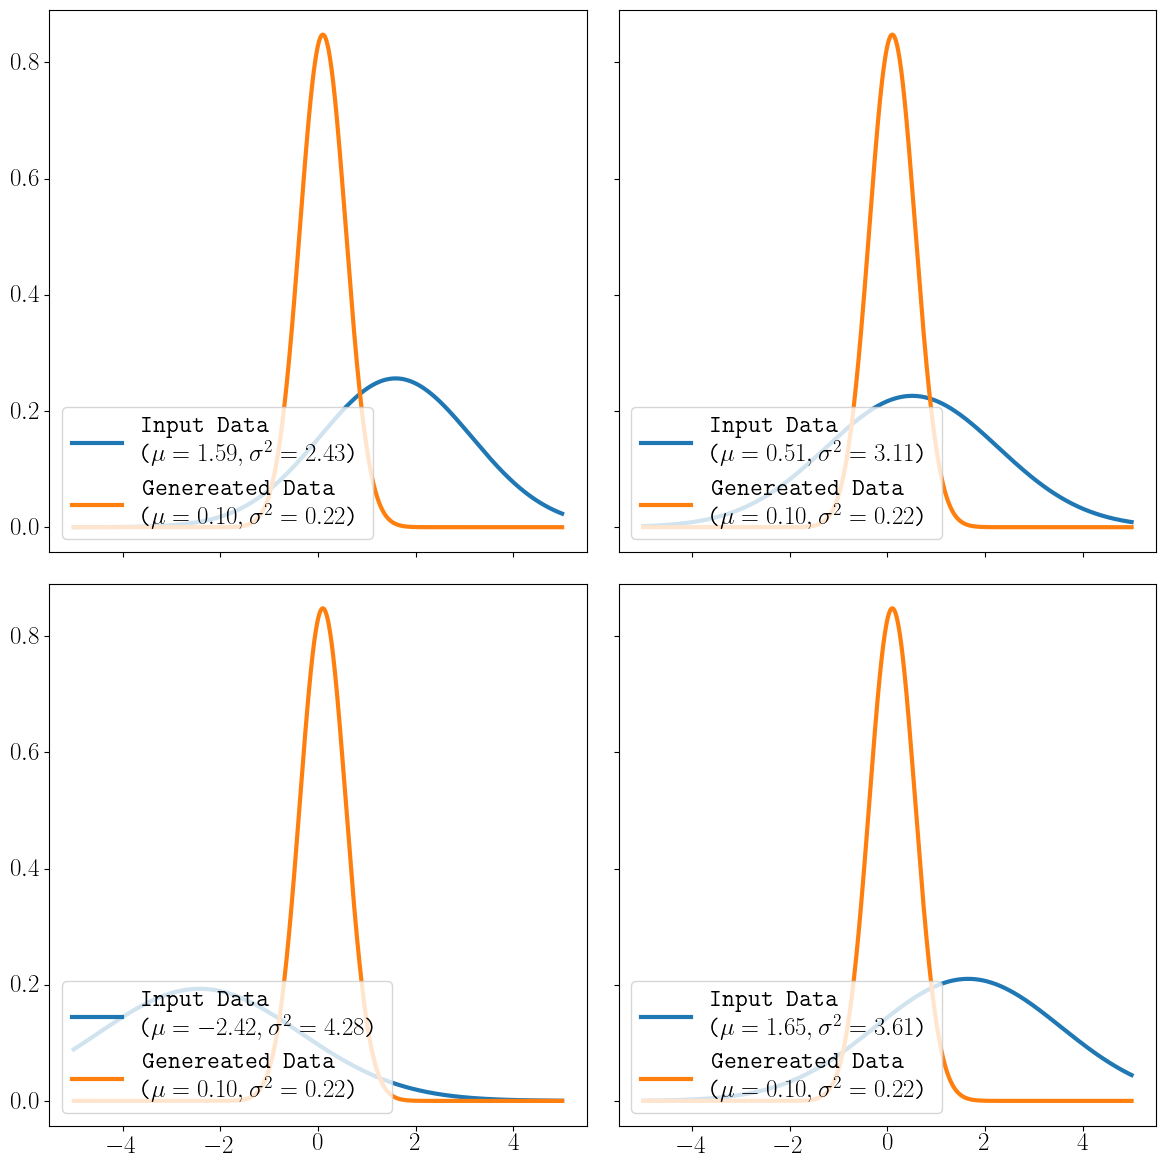

In [8]:
x_axis = x_axis.to('cpu')
encode_model = encode_model.to('cpu')
x_data, y_data = generate_data(x_axis,
                               batch_size=4,
                               mu_minmax=mu_minmax,
                               var_minmax=var_minmax)

y_hat = encode_model(x_data).detach()

fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
for idx, a in enumerate(ax.flat):
    a.plot(x_axis.to('cpu'), x_data[idx].squeeze(),
            label=f'Input Data\n($\mu={y_data[idx, 0]:.2f}, \sigma^2={y_data[idx, 1]:.2f}$)')
    
    if y_hat[idx, 1] < 0:
        print(y_hat[idx, 1])
        y_hat[idx, 1] = 1e-15
    x_hat = Gauss(mu=y_hat[idx, 0], var=y_hat[idx, 1])(x_axis)
    a.plot(x_axis, x_hat,
            label=f'Genereated Data\n($\mu={y_hat[idx, 0]:.2f}, \sigma^2={y_hat[idx, 1]:.2f}$)')

    a.legend(loc='lower left')
plt.tight_layout()

### Quantized Convolution

In [9]:
from torch.testing._internal.common_quantized import override_quantized_engine

def qparams(data, qtype):
    fmax = data.max().item()
    fmin = data.min().item()
    qinfo = torch.iinfo(qtype)
    qmax = qinfo.max
    qmin = qinfo.min
    
    fmin = min(0, fmin)
    fmax = max(0, fmax)
    
    scale = (fmax - fmin) / (qmax - qmin)
    zp = int(qmin - fmin / scale)
    
    return scale, zp

def run_quantized_model(qmodel, data, qtype, qengine='fbgemm'):
    with override_quantized_engine(qengine):
        sc, zp = qparams(data, qtype)
        qdata = torch.quantize_per_tensor(data, sc, zp, qtype)
        qout = qmodel(qdata)
        result = qout.dequantize()
    return result

In [10]:
import copy
import torch

prep_encode_model = copy.deepcopy(encode_model.cpu())

calibration_batches = 10
calibration_batch_size = 32

qengine = 'qnnpack'
with override_quantized_engine(qengine):
    prep_encode_model.qconfig = torch.quantization.default_qconfig
    torch.quantization.prepare(prep_encode_model, inplace=True)
    with torch.no_grad():
        print('Calibrating', end='')
        for batch in range(calibration_batches):
            print('.', end='')
            x_calibration, _ = generate_data(x_axis,
                                             batch_size=calibration_batch_size,
                                             mu_minmax=mu_minmax,
                                             var_minmax=var_minmax)
            prep_encode_model(x_calibration)
        print('Done')
    already_calibrated = True
    qencode_model = torch.quantization.convert(prep_encode_model, inplace=False)

Calibrating..........Done


/home/zafar/Git/pytorch-dev/pytorch-lstm-cm/torch/quantization/observer.py:123: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."


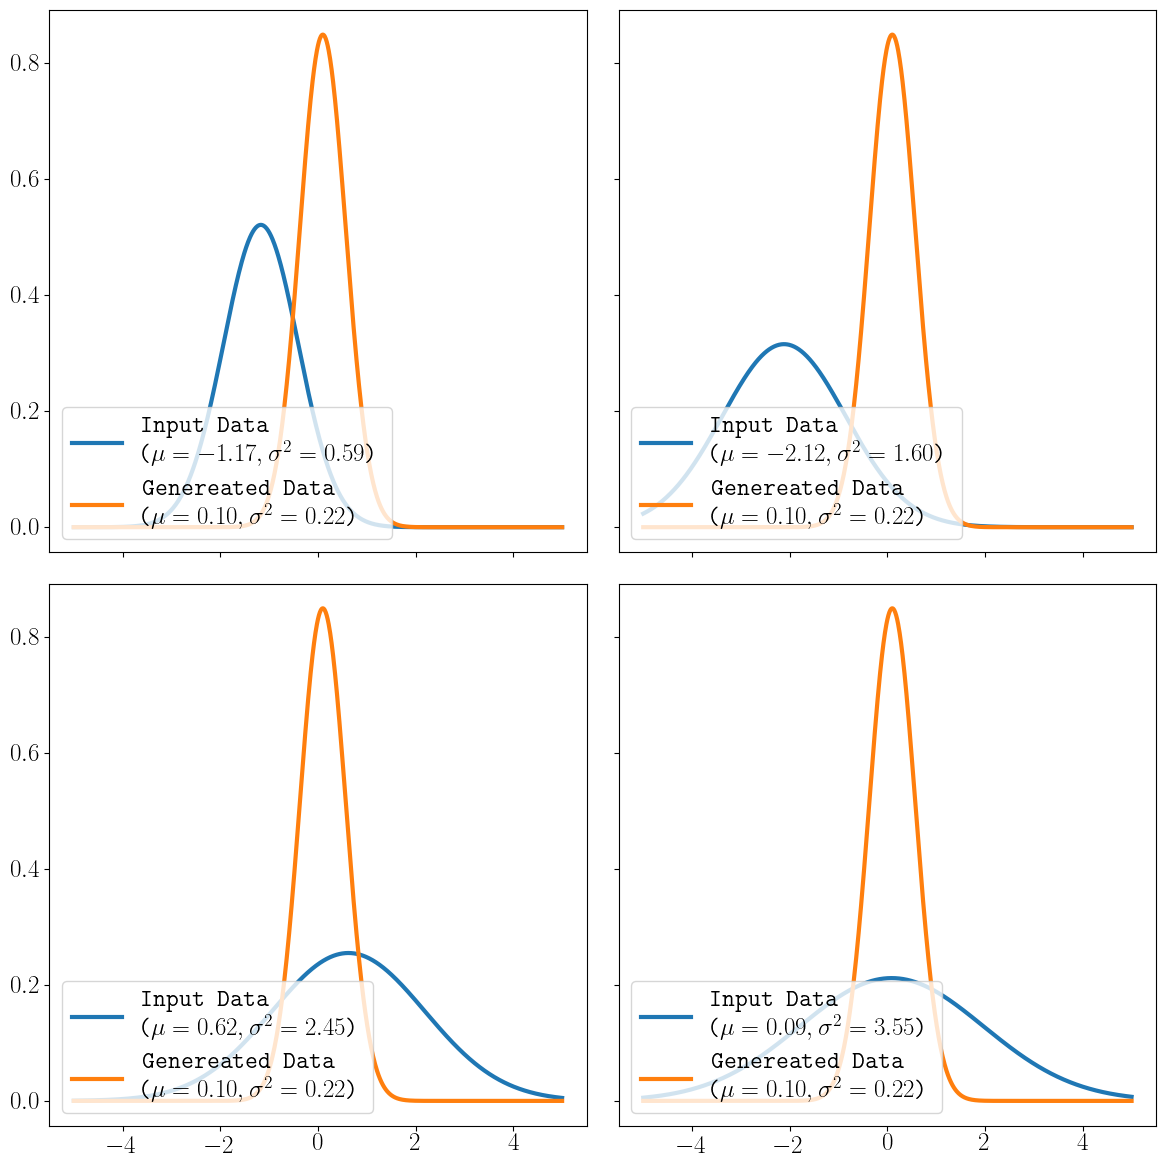

In [11]:
x_axis = x_axis.to('cpu')
x_data, y_data = generate_data(x_axis,
                               batch_size=4,
                               mu_minmax=mu_minmax,
                               var_minmax=var_minmax)

y_hat = run_quantized_model(qencode_model, x_data, torch.quint8, qengine).detach()

fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
for idx, a in enumerate(ax.flat):
    a.plot(x_axis.to('cpu'), x_data[idx].squeeze(),
            label=f'Input Data\n($\mu={y_data[idx, 0]:.2f}, \sigma^2={y_data[idx, 1]:.2f}$)')

    x_hat = Gauss(mu=y_hat[idx, 0], var=y_hat[idx, 1])(x_axis)
    a.plot(x_axis, x_hat,
            label=f'Genereated Data\n($\mu={y_hat[idx, 0]:.2f}, \sigma^2={y_hat[idx, 1]:.2f}$)')

    a.legend(loc='lower left')
plt.tight_layout()

### Deconvolution

In [12]:
class DecoderModel(nn.Module):
    def __init__(self):
        super(DecoderModel, self).__init__()
        self.linear_input = nn.Linear(2, 36)
        self.deconv1 = nn.ConvTranspose1d(1, 7, 1)  # Unsqueeze
        self.act1 = nn.ReLU()
        self.deconv2 = nn.ConvTranspose1d(7, 5, 3, stride=3, output_padding=2)
        self.act2 = nn.ReLU()
        self.deconv3 = nn.ConvTranspose1d(5, 3, 5, stride=3, output_padding=1)
        self.act3 = nn.ReLU()
        self.deconv4 = nn.ConvTranspose1d(3, 1, 7, stride=3, padding=1)
        self.act4 = nn.ReLU()
        
        self.flatten = nn.Flatten()
        self.linear_output = nn.Linear(1001, 1001)
    
    def forward(self, x):
        x = self.linear_input(x)
        x.unsqueeze_(1)  # Unflatten
        x = self.deconv1(x)
        x = self.act1(x)
        x = self.deconv2(x)
        x = self.act2(x)
        x = self.deconv3(x)
        x = self.act3(x)
        x = self.deconv4(x)
        x = self.act4(x)
        x = self.flatten(x)
        x = self.linear_output(x)
        return x

decode_model = DecoderModel()
summary(decode_model, (2,), device='cpu')

--------------------------------------------------------------
        Layer (type)              Output Shape         Param #
            Linear-1                  [-1, 36]             108
   ConvTranspose1d-2               [-1, 7, 36]              14
              ReLU-3               [-1, 7, 36]               0
   ConvTranspose1d-4              [-1, 5, 110]             110
              ReLU-5              [-1, 5, 110]               0
   ConvTranspose1d-6              [-1, 3, 333]              78
              ReLU-7              [-1, 3, 333]               0
   ConvTranspose1d-8             [-1, 1, 1001]              22
              ReLU-9             [-1, 1, 1001]               0
          Flatten-10                [-1, 1001]               0
           Linear-11                [-1, 1001]       1,003,002
     DecoderModel-12                [-1, 1001]       1,003,334
Total params: 2,006,668
Trainable params: 2,006,668
Non-trainable params: 0
------------------------------------------

(tensor(2006668), tensor(2006668))

In [13]:
from torch.nn import functional as F
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available else 'cpu'

decode_model = DecoderModel()
decode_model = decode_model.to(device)

In [14]:
class DecoderCustomLoss:
    def __init__(self, a, b):
        self.a = a
        self.b = b
    def __call__(self, output, target):
        mean_cosine = self.a * torch.mean(1.0 - F.cosine_similarity(output, target))
        l1 = self.b * F.l1_loss(output, target)        
        
        loss = mean_cosine + l1
        loss *= (2 if (output < 0.0).any() else 1.0)
        
#         loss += symmetry_loss(output)
        
        return loss

# criterion = nn.MSELoss()
# criterion = nn.KLDivLoss()
# criterion = nn.SmoothL1Loss()
criterion = DecoderCustomLoss(2.0, 1.0)
optimizer = optim.Adadelta(decode_model.parameters(), lr=1.)

EPOCHS = 50
batch_size = 2048
x_axis = torch.arange(-5.0, 5.0+step_size, step_size).to(device)
mu_minmax = [-2.5, 2.5]
var_minmax = [0.0, 5.0]

x_data, y_data = generate_data(x_axis,
                               batch_size=batch_size,
                               mu_minmax=mu_minmax,
                               var_minmax=var_minmax)
x_data = x_data.to(device)
y_data = y_data.to(device)
decode_model = decode_model.to(device).train()

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    
    x_hat = decode_model(y_data)
    loss = criterion(x_hat, x_data.squeeze(1))
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{EPOCHS}\tLoss: {loss.item()}')

Epoch: 10/50	Loss: 0.8560927510261536
Epoch: 20/50	Loss: 0.5847402811050415
Epoch: 30/50	Loss: 0.3987125754356384
Epoch: 40/50	Loss: 0.3195610046386719
Epoch: 50/50	Loss: 0.30187222361564636


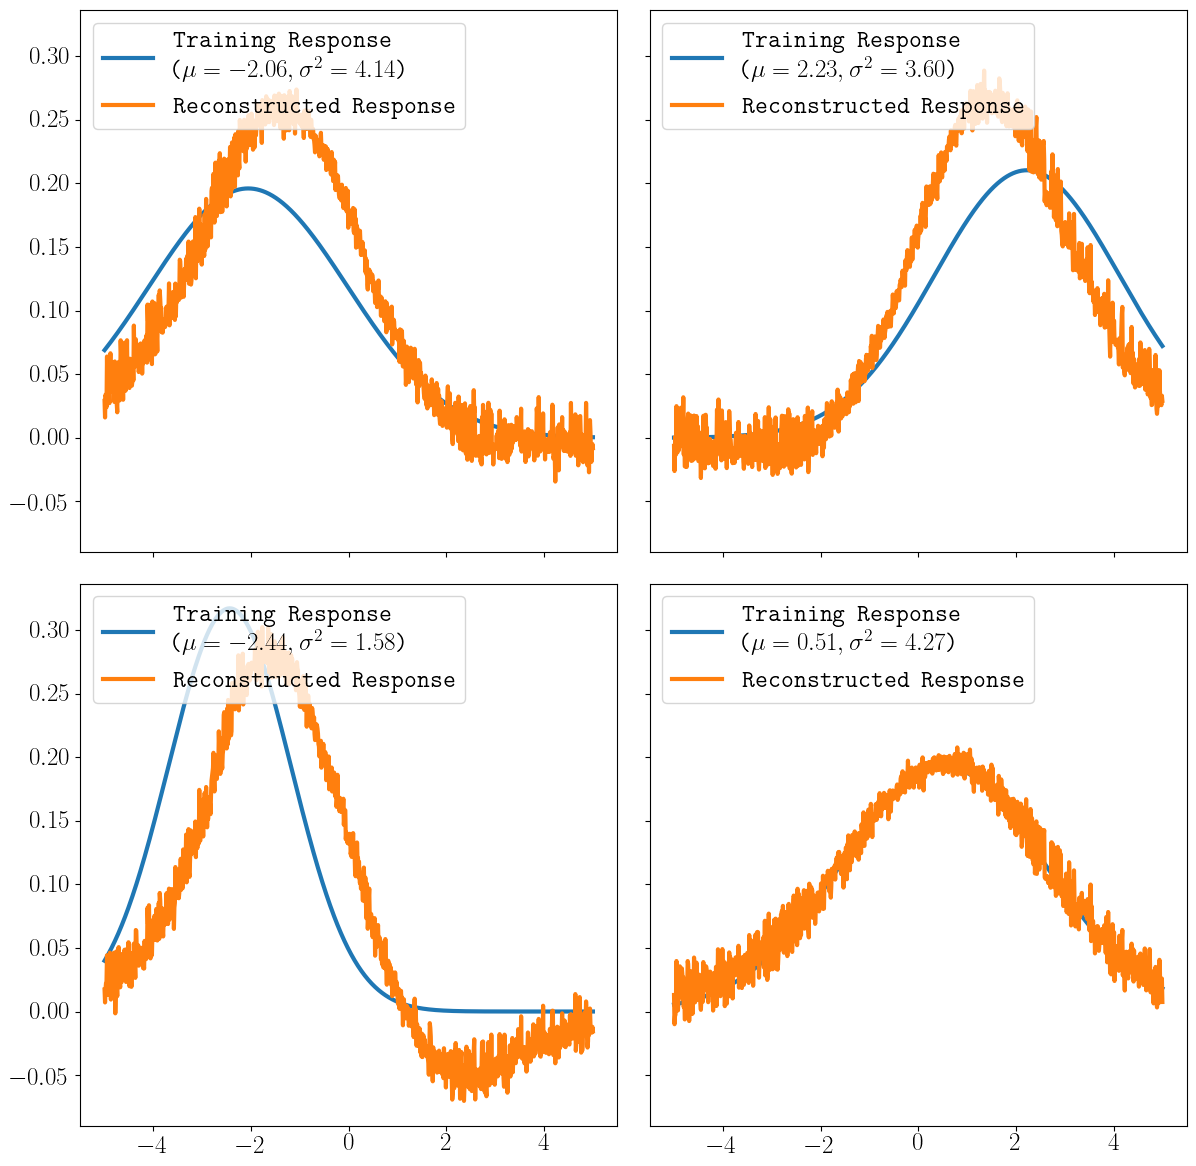

In [15]:
x_axis = x_axis.to('cpu')
decode_model = decode_model.to('cpu').eval()
x_data, y_data = generate_data(x_axis,
                               batch_size=4,
                               mu_minmax=mu_minmax,
                               var_minmax=var_minmax)

x_hat = decode_model(y_data).detach()

fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
for idx, a in enumerate(ax.flat):
    a.plot(x_axis.to('cpu'), x_data[idx].squeeze(),
            label=f'Training Response\n($\mu={y_data[idx, 0]:.2f}, \sigma^2={y_data[idx, 1]:.2f}$)')

    a.plot(x_axis, x_hat[idx],
            label=f'Reconstructed Response')

    a.legend(loc='upper left')
plt.tight_layout()

### Quantized Decoder

In [16]:
prep_decode_model = copy.deepcopy(decode_model)

calibration_batches = 10
calibration_batch_size = 32

qengine = 'qnnpack'
with override_quantized_engine(qengine):
    prep_decode_model.qconfig = torch.quantization.default_qconfig
    torch.quantization.prepare(prep_decode_model, inplace=True)
    with torch.no_grad():
        print('Calibrating', end='')
        for batch in range(calibration_batches):
            print('.', end='')
            _, x_calibration = generate_data(x_axis,
                                             batch_size=calibration_batch_size,
                                             mu_minmax=mu_minmax,
                                             var_minmax=var_minmax)
            prep_decode_model(x_calibration)
        print('Done')
    already_calibrated = True
    qdecode_model = torch.quantization.convert(prep_decode_model, inplace=False)

Calibrating..........Done


/home/zafar/Git/pytorch-dev/pytorch-lstm-cm/torch/quantization/observer.py:123: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."


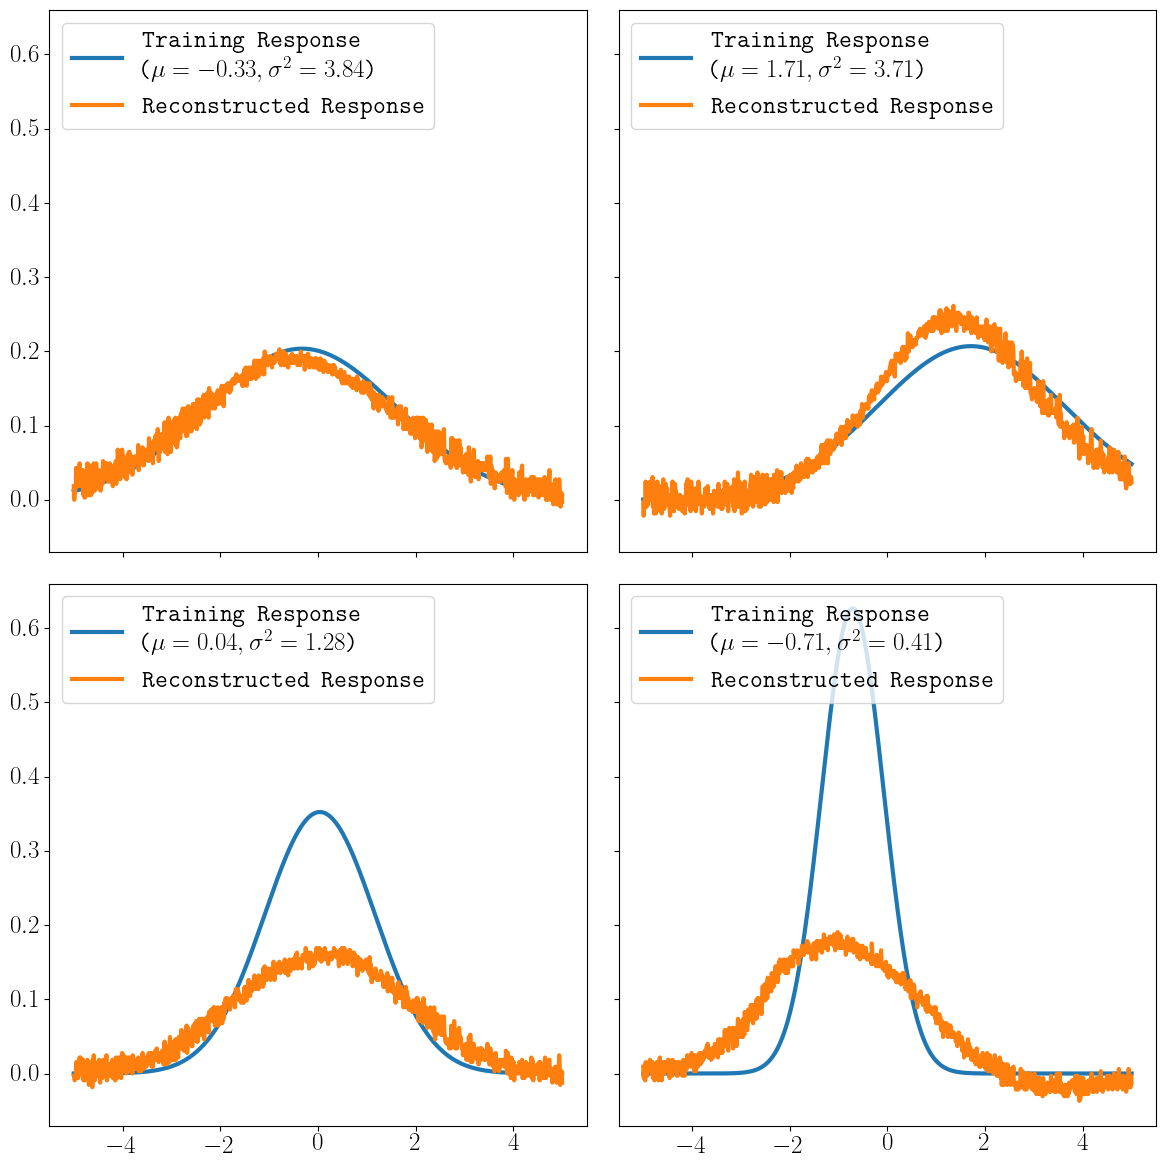

In [17]:
x_axis = x_axis.to('cpu')

x_data, y_data = generate_data(x_axis,
                               batch_size=4,
                               mu_minmax=mu_minmax,
                               var_minmax=var_minmax)

x_hat = run_quantized_model(qdecode_model, y_data, torch.quint8, qengine)

fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
for idx, a in enumerate(ax.flat):
    a.plot(x_axis.to('cpu'), x_data[idx].squeeze(),
            label=f'Training Response\n($\mu={y_data[idx, 0]:.2f}, \sigma^2={y_data[idx, 1]:.2f}$)')

    a.plot(x_axis, x_hat[idx],
            label=f'Reconstructed Response')

    a.legend(loc='upper left')
plt.tight_layout()

### Autoencoder

In [18]:
decode_model.deconv1.weight.shape

torch.Size([1, 7, 1])